In [1]:
import pandas as pd
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Vegetation Classification using Machine Learning

## Load Data

In [2]:
# Load all the classes into different Dataframes

class1 = pd.read_csv('data/Data_Class_1.csv')
class3 = pd.read_csv('data/Data_Class_3.csv')
class6 = pd.read_csv('data/Data_Class_6.csv')

## Descriptive Statistics

In [3]:
# Combine all classes into one dataset and view the top rows

data = pd.concat([class1, class3, class6], ignore_index=True)
data

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type,Wilderness_Area,Vegetation_Type
0,41,2699,347,3,0,0,2096,213,234,159,6853,37.32,282.46,125.22,6.23,Type_20,Area_1,Type_1
1,52,2739,323,25,85,43,3118,149,205,192,6219,76.51,182.57,532.19,30.65,Type_29,Area_1,Type_1
2,53,2696,72,2,30,0,3271,222,234,149,6071,86.37,374.79,275.52,59.96,Type_30,Area_1,Type_1
3,56,2722,315,24,30,19,3216,148,212,200,6132,85.31,364.30,1182.48,22.21,Type_16,Area_1,Type_1
4,68,2919,13,13,90,6,5321,207,214,142,4060,78.13,303.26,1198.69,14.22,Type_29,Area_1,Type_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,15106,2480,10,21,150,38,607,193,194,133,1436,82.97,247.13,190.52,45.88,Type_10,Area_3,Type_6
5936,15110,2600,57,19,0,0,731,229,197,93,1332,38.82,163.93,853.03,34.03,Type_10,Area_3,Type_6
5937,15111,2508,33,26,67,1,644,204,173,91,1385,75.93,366.25,442.88,6.98,Type_10,Area_3,Type_6
5938,15112,2610,59,17,60,10,674,231,202,98,1328,74.65,312.00,651.50,55.74,Type_10,Area_3,Type_6


In [4]:
# Check data types and non-null counts

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Id                                  5940 non-null   int64  
 1   Altitude                            5940 non-null   int64  
 2   Slope_Orientation                   5940 non-null   int64  
 3   Slope                               5940 non-null   int64  
 4   Horizontal_Distance_To_Water        5940 non-null   int64  
 5   Vertical_Distance_To_Water          5940 non-null   int64  
 6   Horizontal_Distance_To_Roadways     5940 non-null   int64  
 7   Shadow_Index_9h                     5940 non-null   int64  
 8   Shadow_Index_12h                    5940 non-null   int64  
 9   Shadow_Index_15h                    5940 non-null   int64  
 10  Horizontal_Distance_To_Fire_Points  5940 non-null   int64  
 11  Canopy_Density                      5940 no

According to this information:
- 5940 rows
- 18 columns
- No null values
- 3 categorical columns and 15 numerical columns

### Numerical Columns
View some metrics of each numerical column

In [5]:
# Generate descriptive statistics of the numerical columns

data.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000
max,15118.000000,3675.000000,360.000000,52.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,248.000000,6993.000000,89.990000,449.970000,1199.880000,64.990000


As displayed above, we can identify the following data characteristics:
- The columns have different ranges of values
- Some columns like the horizontal_distance_to_water have a significant difference between the mean and the median, indicating a possible skewness in the data
- When comparing the third quartile and the maximum value, we can see that some columns have outliers since the maximum value is significantly higher than the third quartile
- The same can be said for the minimum value and the first quartile, where the minimum value is significantly lower than the first quartile
- The standard deviation of the features possess a wide range of magnitudes, indicating that in some columns the data is spread out from the mean

### Categorical columns

In [6]:
# Generate descriptive statistics of the categorical columns

data.describe(include='object')

,Soil_Type,Wilderness_Area,Vegetation_Type
count,5940,5940,5940
unique,32,4,3
top,Type_10,Area_3,Type_1
freq,1634,2529,2160


The categorical columns have the following characteristics:
- We have two columns with few unique values and one column with many unique values. We need to take this into account when encoding the data.
- The most frequent values of each column are present in at least 25% of the rows

## Univariate Analysis

In [7]:
# Get the name of the numerical and categorical columns

numerical_columns = data.select_dtypes(exclude='object').columns.drop('Id')
categorical_columns = data.select_dtypes(include='object').columns

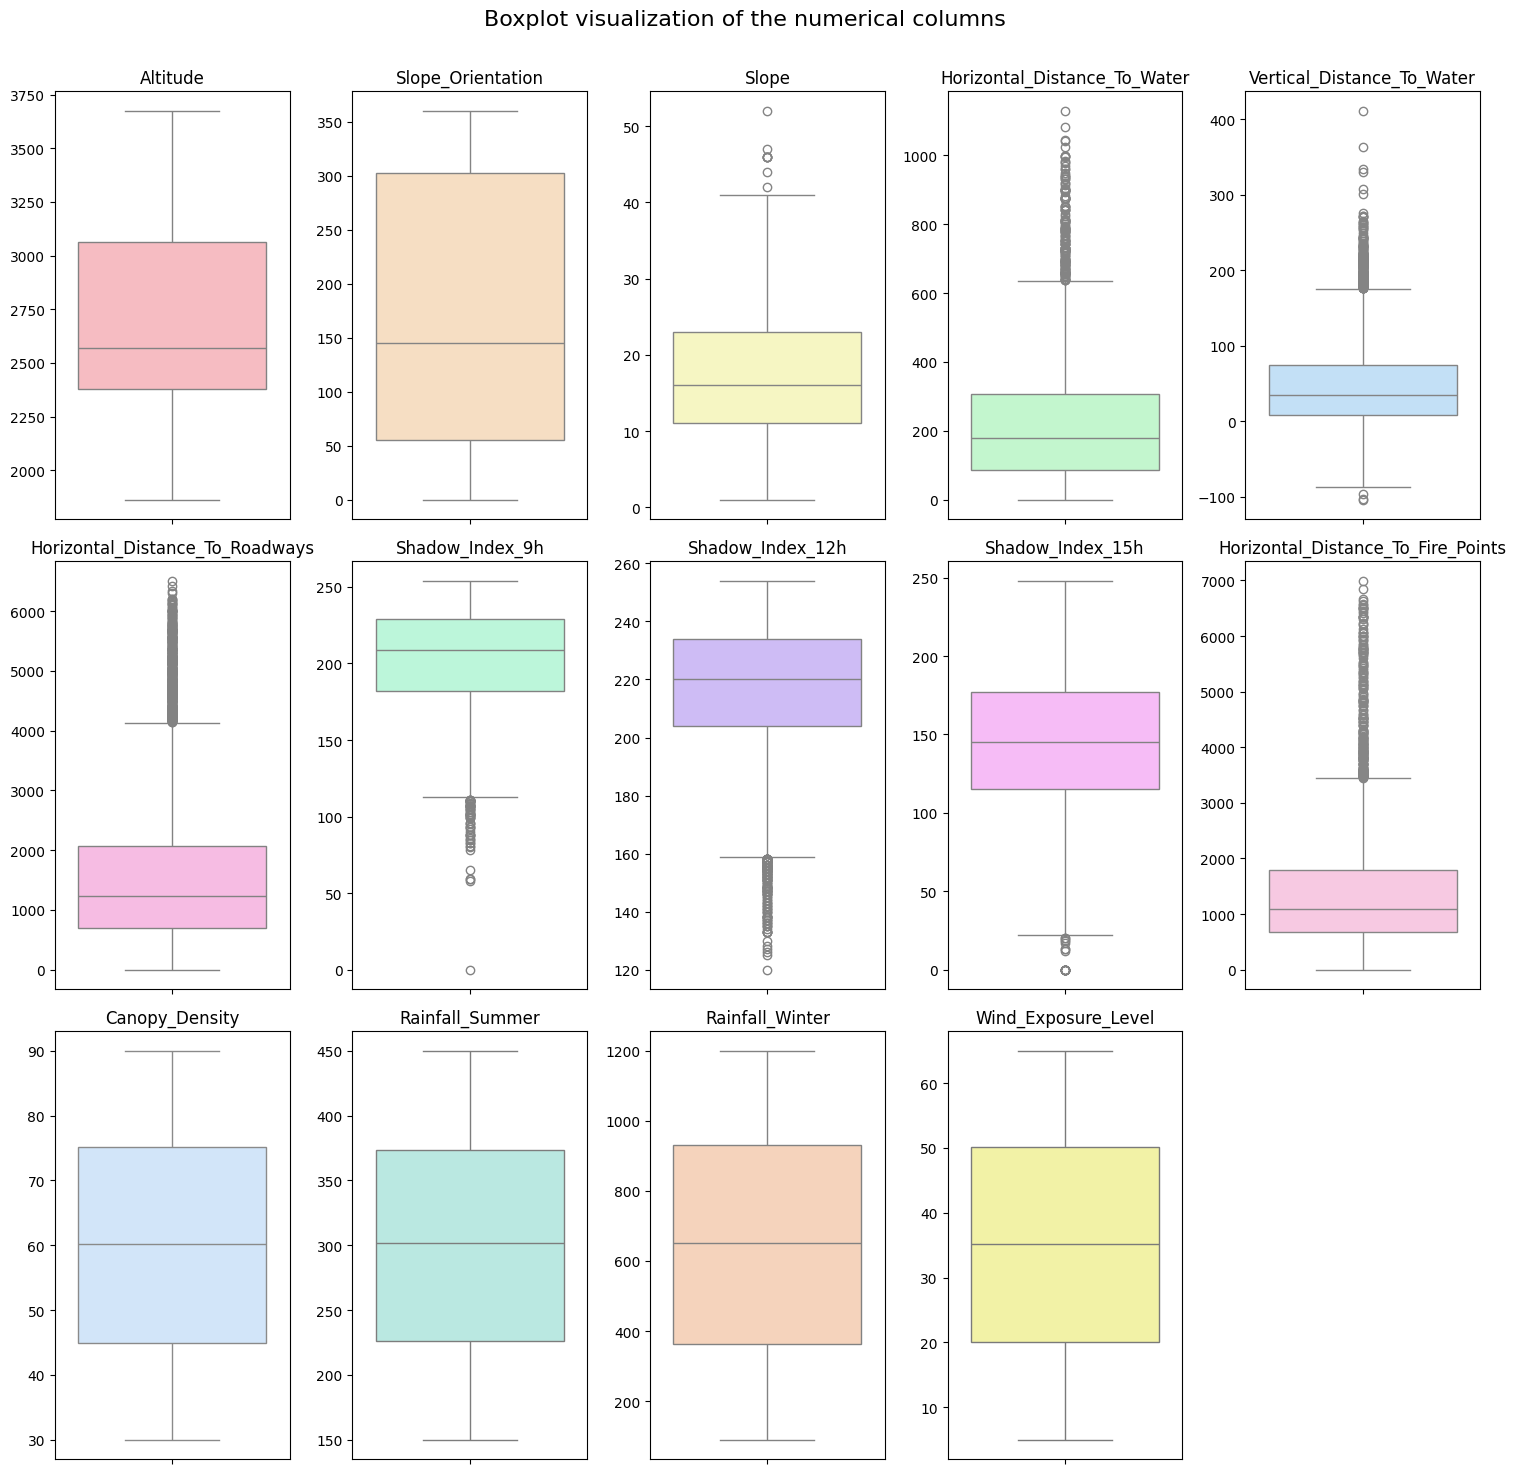

In [8]:
# Draw the boxplot visualizations of the numerical columns

boxplot_visualization(data, numerical_columns, 'Boxplot visualization of the numerical columns')

- Several columns such as the Horizontal_Distance_To_Water, Horizontal_Distance_To_Roadways, and Horizontal_Distance_To_Fire_Points have a significant number of outliers. 
These outliers may appear since different types of vegetation may have very distinct characteristics and values linked to them. If further investigation reveals that it is not the case, they may affect the performance of the models and it might be important to consider removing them.
- Given the length of the boxes, the majority of the data contains less variability since have narrow boxes. The Slope_Orientation column has a wide box, so we can identify that the values have more variability.

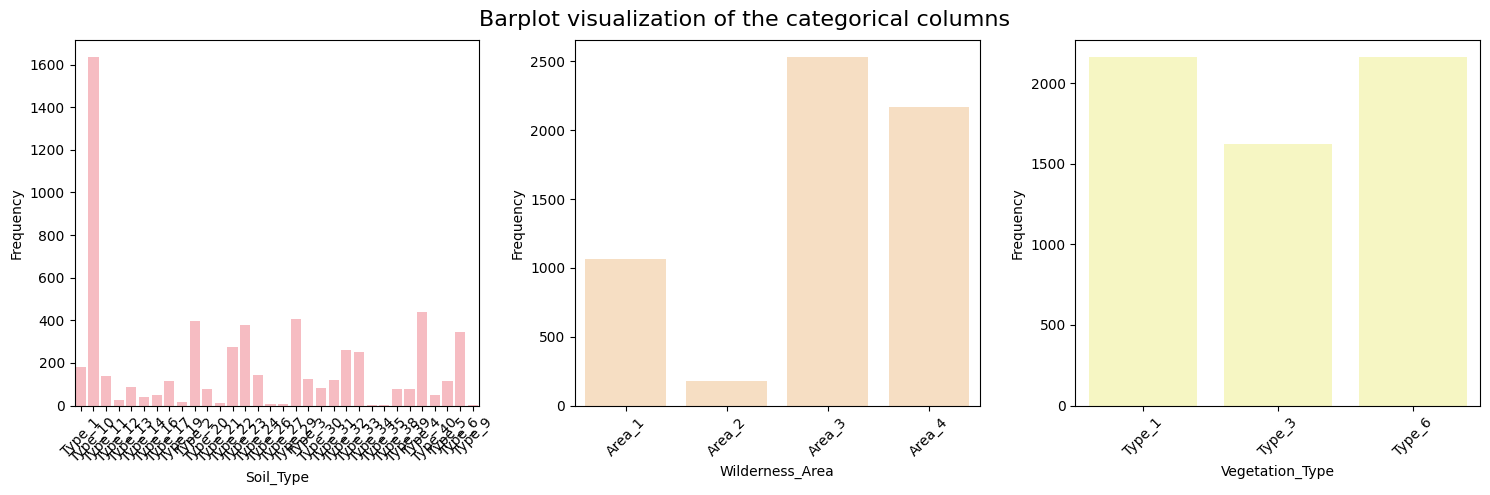

In [9]:
# Draw the barplot visualizations of the categorical columns

barplot_visualization(data, categorical_columns, 'Barplot visualization of the categorical columns')

- Given the distribution of the categorical columns there are clear outliers in the Soil_Type and Wilderness_Area.
- Our classes appear in similar frequencies and it suggests that we will not encounter issues related to class imbalance, which is a crucial information to have in mind when evaluating the models.

## Bivariate Analysis

In [10]:
# Encode the categorical columns

encoded_data = data.copy()
encoded_data['Soil_Type_Enc'] = pd.factorize(data['Soil_Type'])[0]
encoded_data['Wilderness_Area_Enc'] = pd.factorize(data['Wilderness_Area'])[0]
encoded_data['Vegetation_Type_Enc'] = pd.factorize(data['Vegetation_Type'])[0]

In [11]:
# Generate descriptive statistics of data after encoding

encoded_data.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type_Enc,Wilderness_Area_Enc,Vegetation_Type_Enc
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199,15.752862,1.581650,1.000000
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532,8.008764,1.153733,0.852875
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000,0.000000,0.000000,0.000000
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000,10.000000,1.000000,0.000000
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000,18.000000,1.000000,1.000000
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000,18.000000,3.000000,2.000000
max,15118.000000,3675.000000,360.000000,52.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,248.000000,6993.000000,89.990000,449.970000,1199.880000,64.990000,31.000000,3.000000,2.000000


The encoded data has the following characteristics:
- The columns have different ranges of values, since the encoding was done based on the number of unique values in each column
- The mean and median values are close to each other, indicating that the data is not skewed
- The column with the highest standard deviation is the Soil_Type_Enc column, indicating that the data is spread out from the mean


In [12]:
# Remove Id for correlation matrix

encoded_data_without_id = encoded_data.drop('Id', axis=1)

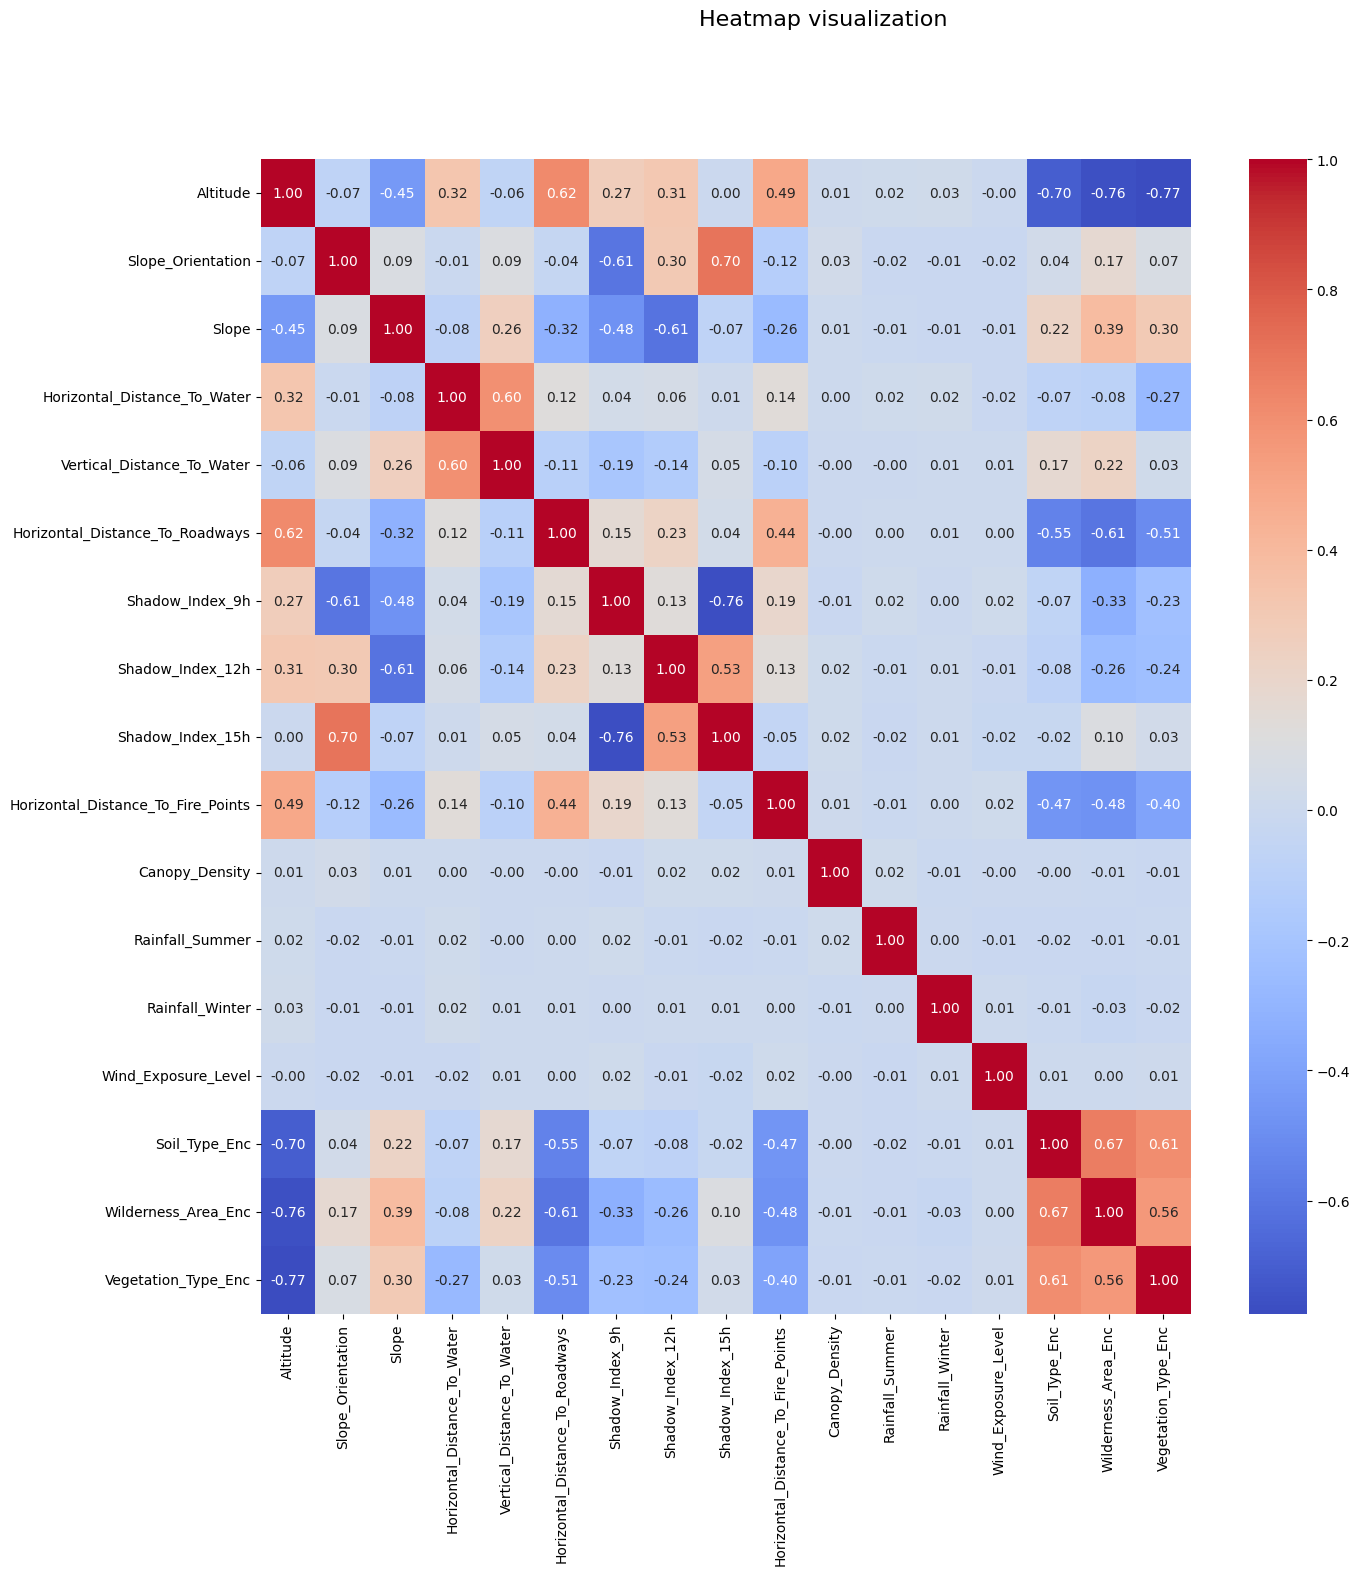

In [13]:
# Generate heatmap of the data

heatmap_visualization(encoded_data_without_id, 'Heatmap visualization')

The correlation of the features with the target column varies a lot and we can see that we have both highly correlated and uncorrelated features. The first ones may be the most important for our analysis, while the second ones may not provide any benefit.
In the next step, the columns with close to 0 correlation with the target column will be deleted, seeing as these do not provide any benefit to our analysis.

This applies to the following columns:
- Canopy_Density
- Rainfall_Summer
- Rainfall_Winter
- Wind_Exposure_Level

In [14]:
# Removing the columns without any correlation

encoded_data_without_id = encoded_data_without_id.drop(['Canopy_Density', 'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'], axis=1)

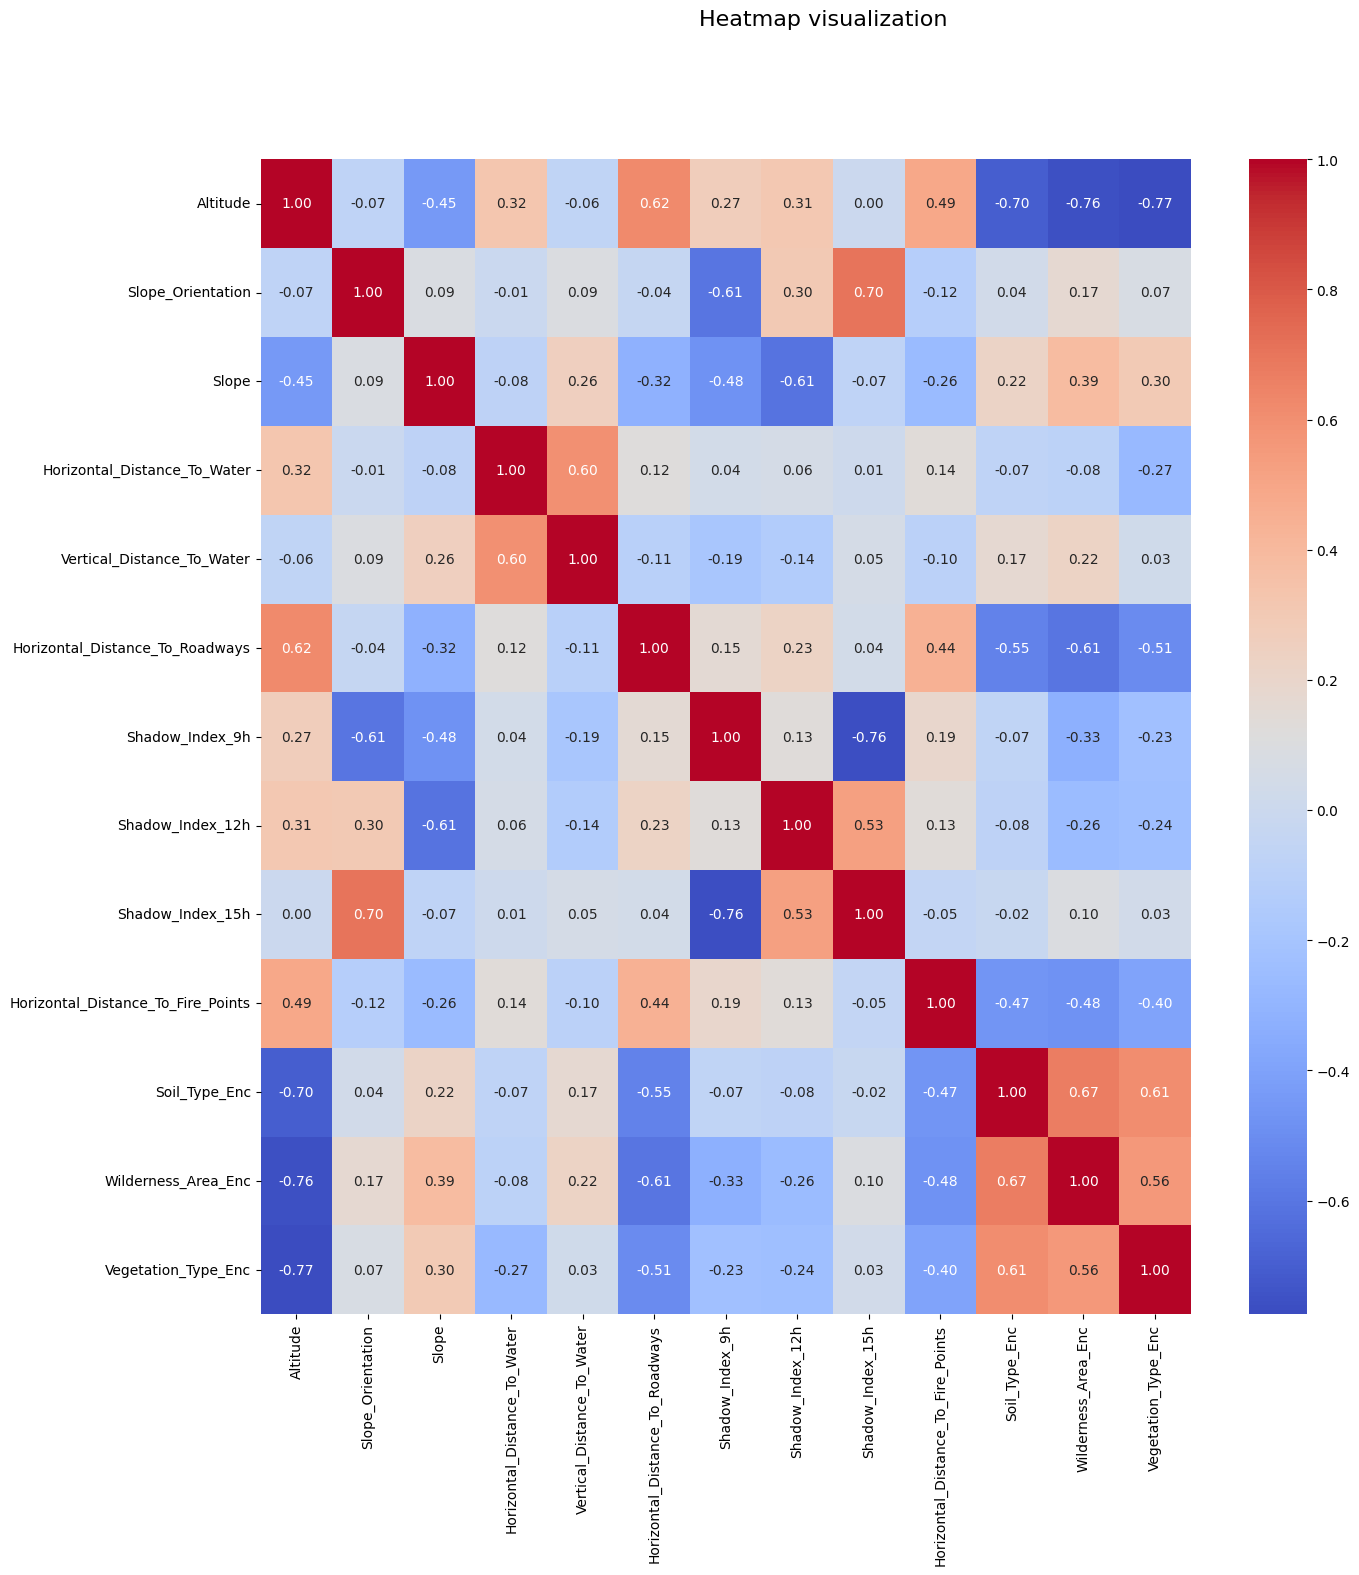

In [15]:
# Generate the heatmap of the data after removing the columns

heatmap_visualization(encoded_data_without_id, 'Heatmap visualization')

- Without the columns that do not correlate with the target column, we can see that the correlation between the features and the target column is more evident. All these columns may help, to some extent, to predict the target column.

In [16]:
# Display the correlation matrix

corr_matrix = encoded_data_without_id.corr(numeric_only=True)
corr_matrix['Vegetation_Type_Enc'].sort_values()

Altitude                             -0.774637
Horizontal_Distance_To_Roadways      -0.510261
Horizontal_Distance_To_Fire_Points   -0.400223
Horizontal_Distance_To_Water         -0.269011
Shadow_Index_12h                     -0.238884
Shadow_Index_9h                      -0.227859
Vertical_Distance_To_Water            0.028331
Shadow_Index_15h                      0.034780
Slope_Orientation                     0.074433
Slope                                 0.298247
Wilderness_Area_Enc                   0.560754
Soil_Type_Enc                         0.608980
Vegetation_Type_Enc                   1.000000
Name: Vegetation_Type_Enc, dtype: float64

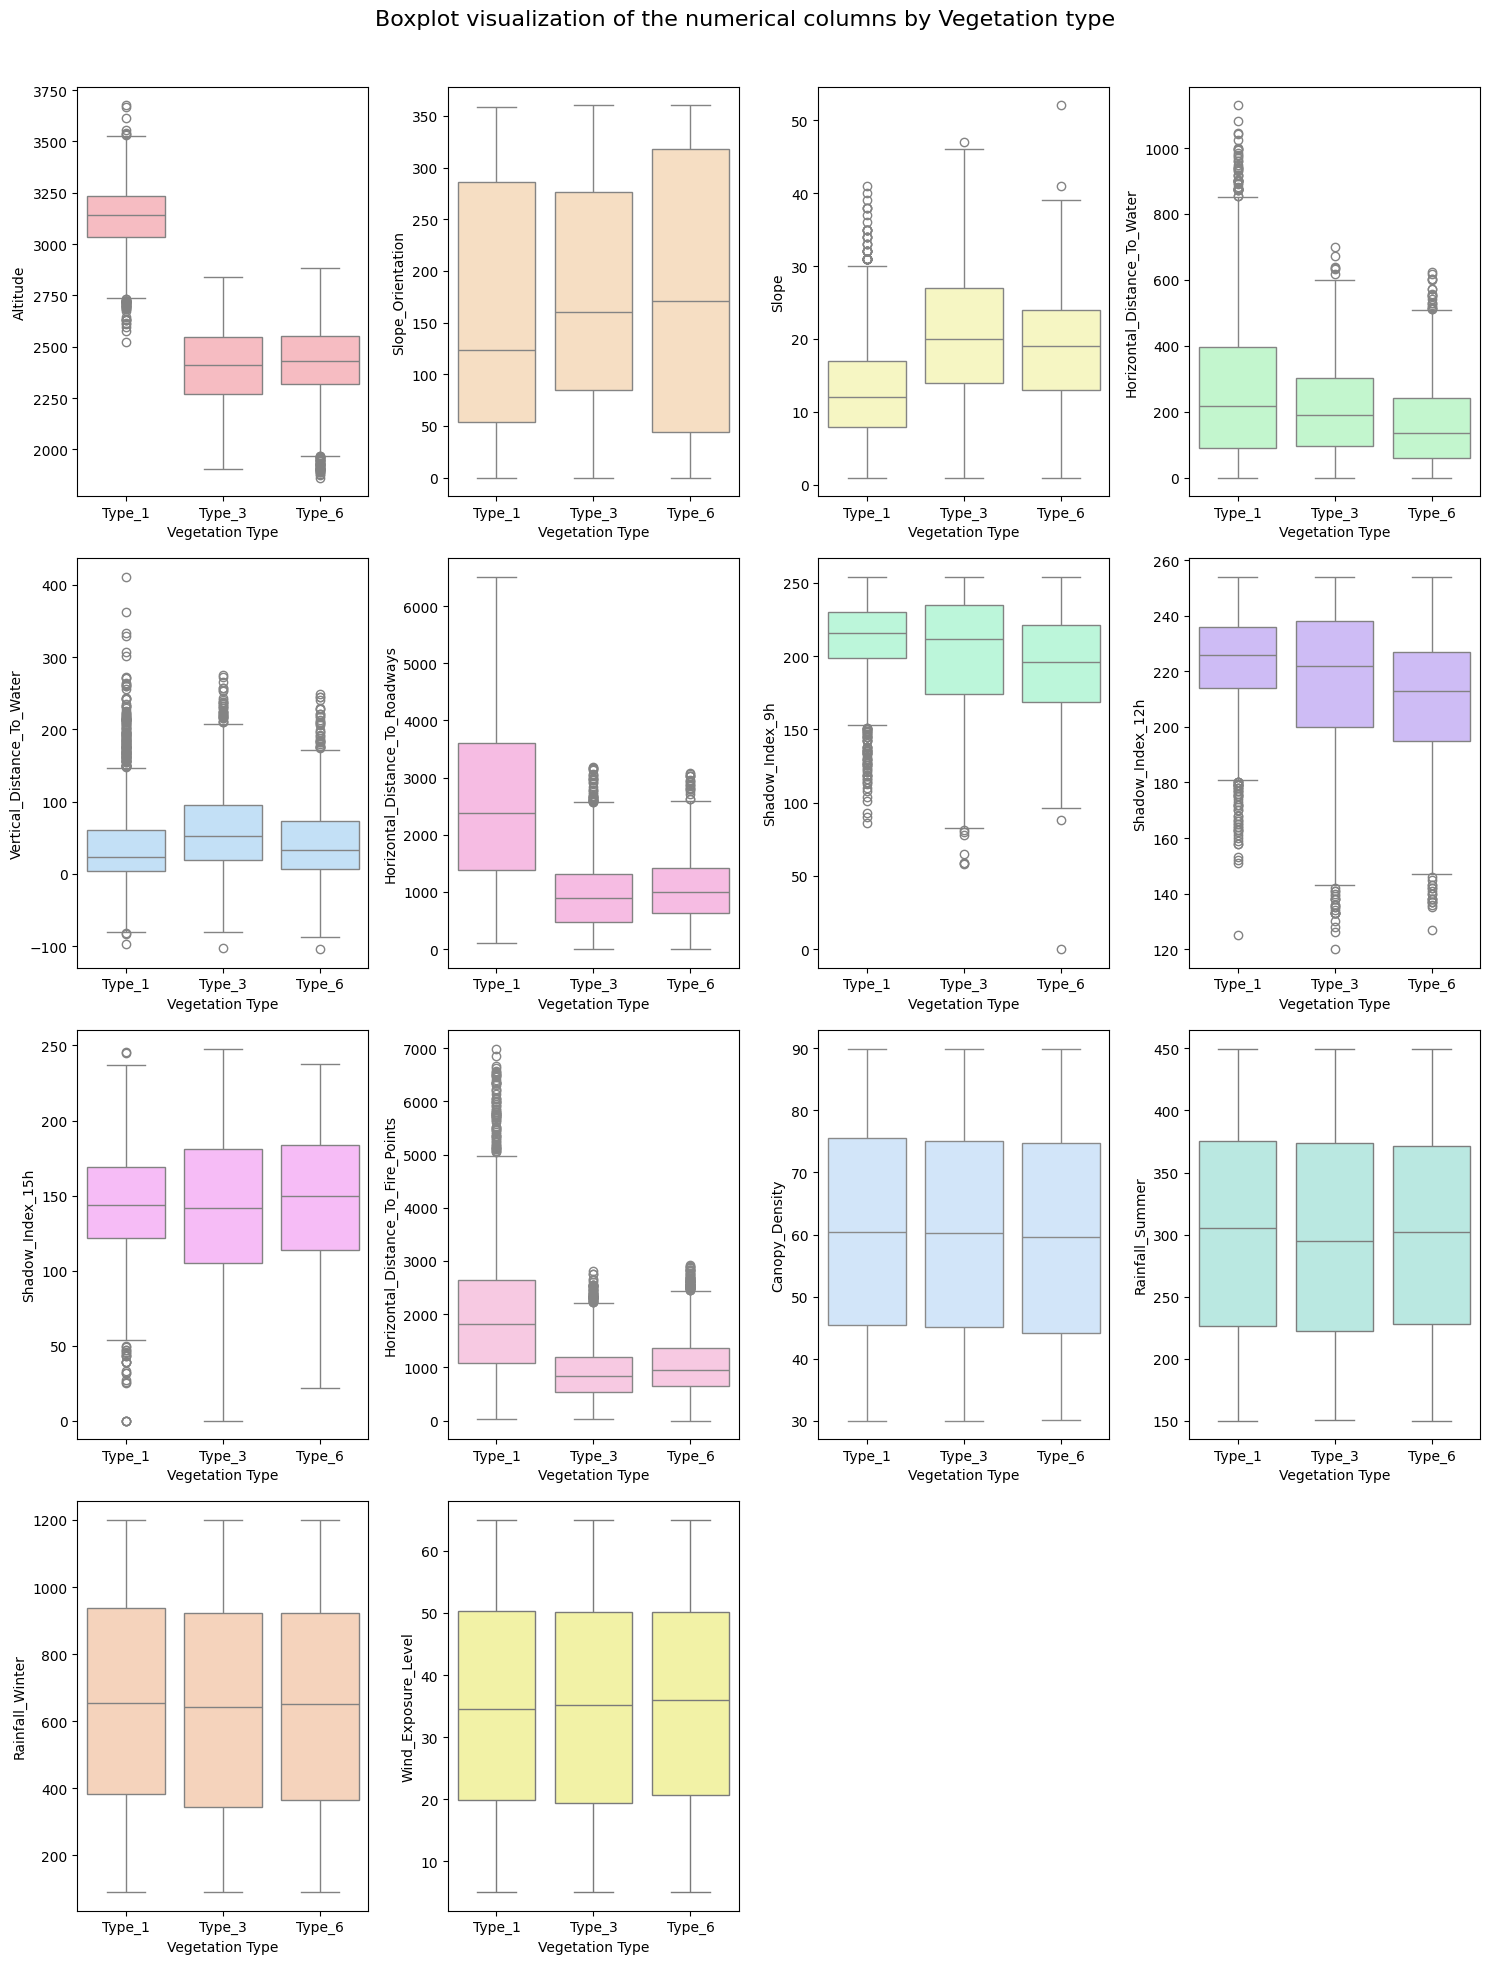

In [17]:
# Draw the boxplot visualizations of the numerical columns by Vegetation type (Target variable)

boxplot_by_type_visualization(data, numerical_columns, 'Boxplot visualization of the numerical columns by Vegetation type')

- In the boxplots there are some columns that have outliers for each different Vegetation_Type.
- Some features like the Altitude, Horizontal_Distance_To_Roadways, slope and Horizontal_Distance_To_Fire_Points have very distinct boxes for the Type_1 of the target variable. This indicates that these columns might be very good predictors of the label.

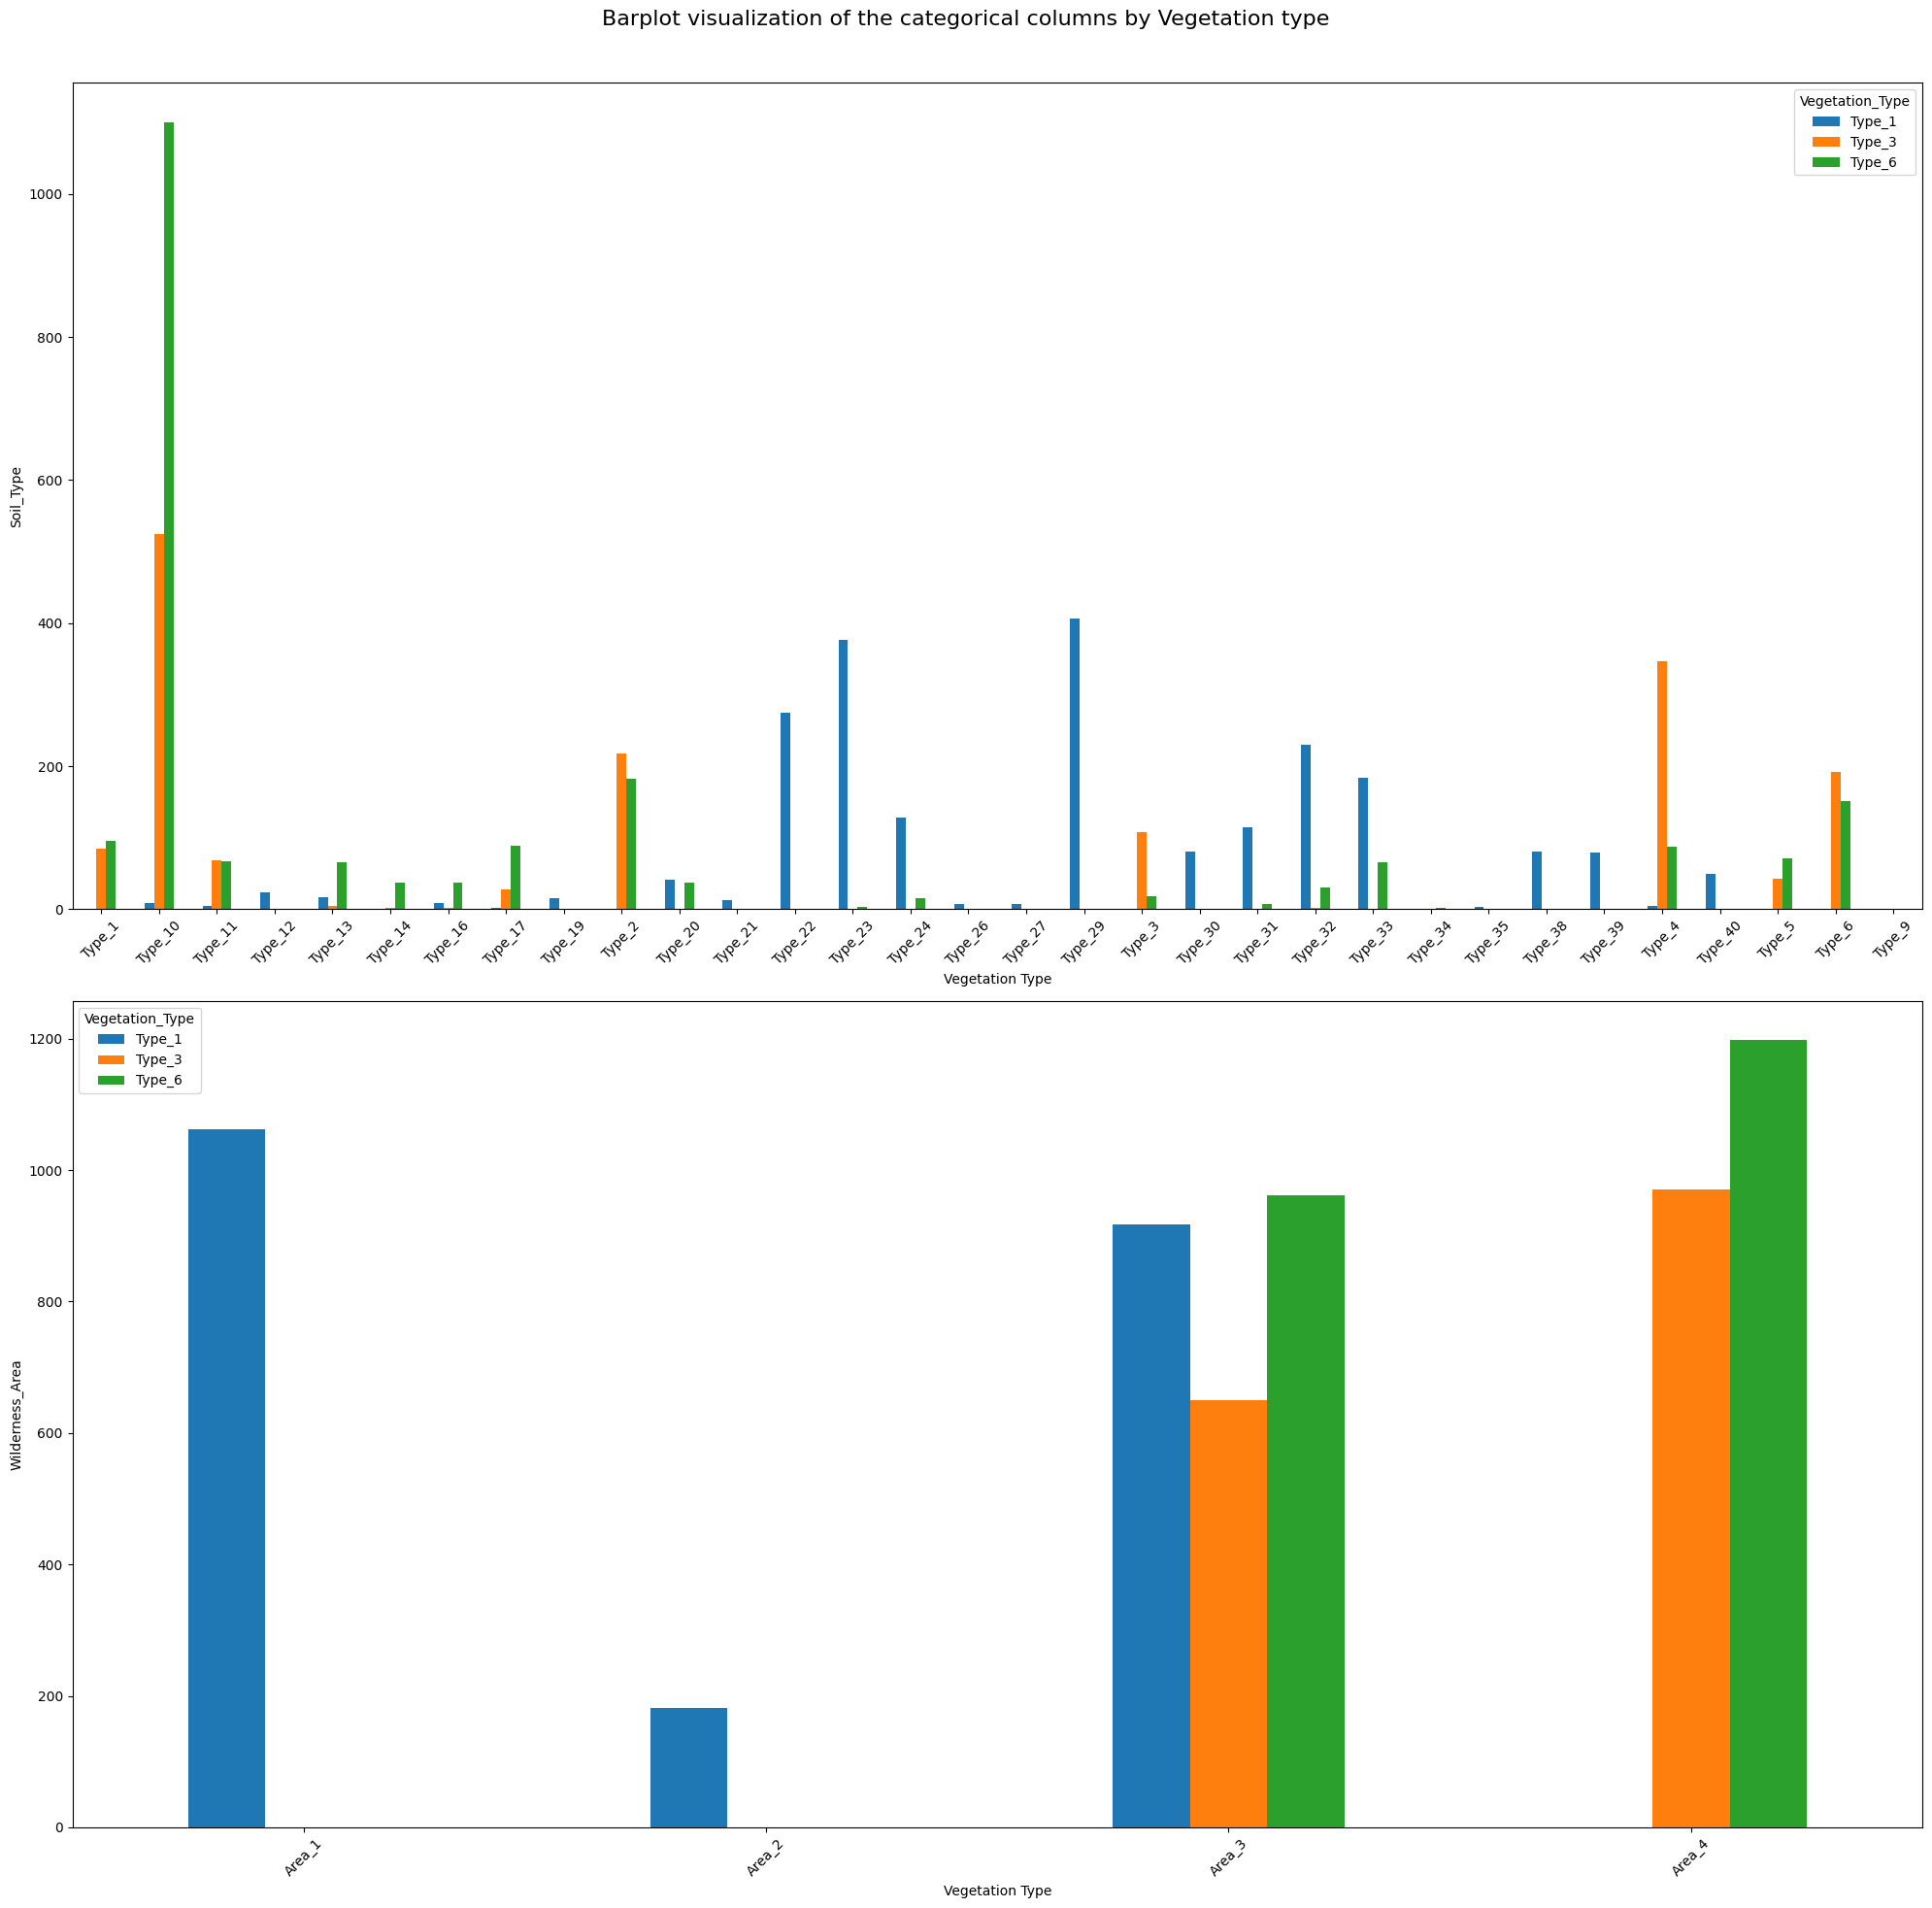

In [18]:
# Draw the crosstable visualizations of the numerical columns by Vegetation type (Target variable)

crosstab_by_type_visualization(data, categorical_columns, 'Barplot visualization of the categorical columns by Vegetation type')

- The crosstables show that some values of the categorical features are more frequent or even exclusive in some classes than in others. This indicates that these columns may be good predictors of the target variable.

## Methods Application

In [19]:
# Load the models to be evaluated

models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

### Data Preparation

In [20]:
# Divide the data into features and target variable and separate the training and test data

X = encoded_data.drop(columns=['Vegetation_Type', 'Soil_Type', 'Wilderness_Area','Vegetation_Type_Enc', 'Id'])
y = encoded_data['Vegetation_Type_Enc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Rescales each feature to have a mean of 0 and a standard deviation of 1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Dataframe to store the metrics for each model and method

data_results = pd.DataFrame(columns=['Model', 'Method', 'Accuracy', 'Precision', 'Recall', 'F1', 'Std Dev', 'Confusion Matrix'])

- Since our dataset is balanced, we can use the accuracy metric to evaluate the models since it gives us a good overview of the model's performance.
- It is also useful to use the precision, recall to ensure that the model is not biased towards a specific class. Given the fact that we want to balance the precision and recall, the F1 score is a good metric to use.
- The confusion matrix will help identify misclassifications since it shows the number of correct and incorrect predictions for each class.

### Holdout Method

In [23]:
holdout_evaluation(data_results,models, X_train, X_test, y_train, y_test)

### Cross Validation (K=5)

In [24]:
cross_validation_evaluation(data_results,models, X, y, 5)

### Cross Validation (K=10)

In [25]:
cross_validation_evaluation(data_results,models, X, y, 10)

### Leave One Out Cross Validation (LOOCV)

In [26]:
#loocv_evaluation(data_results, models, X, y)

### Bootstrap

In [27]:
bootstrap_evaluation(data_results, models,X, y, 100)

### Results 

In [28]:
# Display the dataframe with the metrics for each model and method

data_results

,Model,Method,Accuracy,Precision,Recall,F1,Std Dev,Confusion Matrix
0,Logistic Regression,Holdout,0.799102,0.801022,0.799102,0.795422,Nan,"[[656, 1, 13], [1, 257, 224], [4, 115, 511]]"
1,LDA,Holdout,0.794613,0.797298,0.794613,0.789970,Nan,"[[654, 1, 15], [0, 249, 233], [10, 107, 513]]"
2,QDA,Holdout,0.807520,0.810205,0.807520,0.805016,Nan,"[[652, 6, 12], [0, 270, 212], [2, 111, 517]]"
3,Logistic Regression,Cross-Validation with 5,0.798822,0.799251,0.798822,0.794894,0.005952,"[[2130, 3, 27], [2, 870, 748], [15, 400, 1745]]"
4,LDA,Cross-Validation with 5,0.794444,0.794859,0.794444,0.789895,0.0067,"[[2126, 3, 31], [0, 851, 769], [31, 387, 1742]]"
5,QDA,Cross-Validation with 5,0.805724,0.807798,0.805724,0.803017,0.005172,"[[2107, 14, 39], [0, 908, 712], [7, 382, 1771]]"
6,Logistic Regression,Cross-Validation with 10,0.799663,0.800198,0.799663,0.795706,0.020797,"[[2129, 3, 28], [1, 874, 745], [17, 396, 1747]]"
7,LDA,Cross-Validation with 10,0.795118,0.796028,0.795118,0.790459,0.018763,"[[2125, 4, 31], [0, 849, 771], [30, 381, 1749]]"
8,QDA,Cross-Validation with 10,0.808923,0.811558,0.808923,0.806046,0.014526,"[[2106, 14, 40], [0, 912, 708], [8, 365, 1787]]"
9,Logistic Regression,Bootstrap,0.796525,0.796535,0.796525,0.792745,0.005988,"[[106032, 190, 1360], [144, 43161, 36828], [93..."


- As we can see above, the models have similar results since the accuracy, precision, recall and F1 scores are in the range of 0.78 to 0.80. This can indicate that the performance of the models is consistent.
- As the variance equals to the square of the standard deviation, we can conclude that the resampling method have an impact on the results. The methods with the lowest variance are the Cross Validation with K=5 and the Bootstrap. Cross Validation with K=10 has the highest variance and Holdout method does not have a variance since it is a single split. 

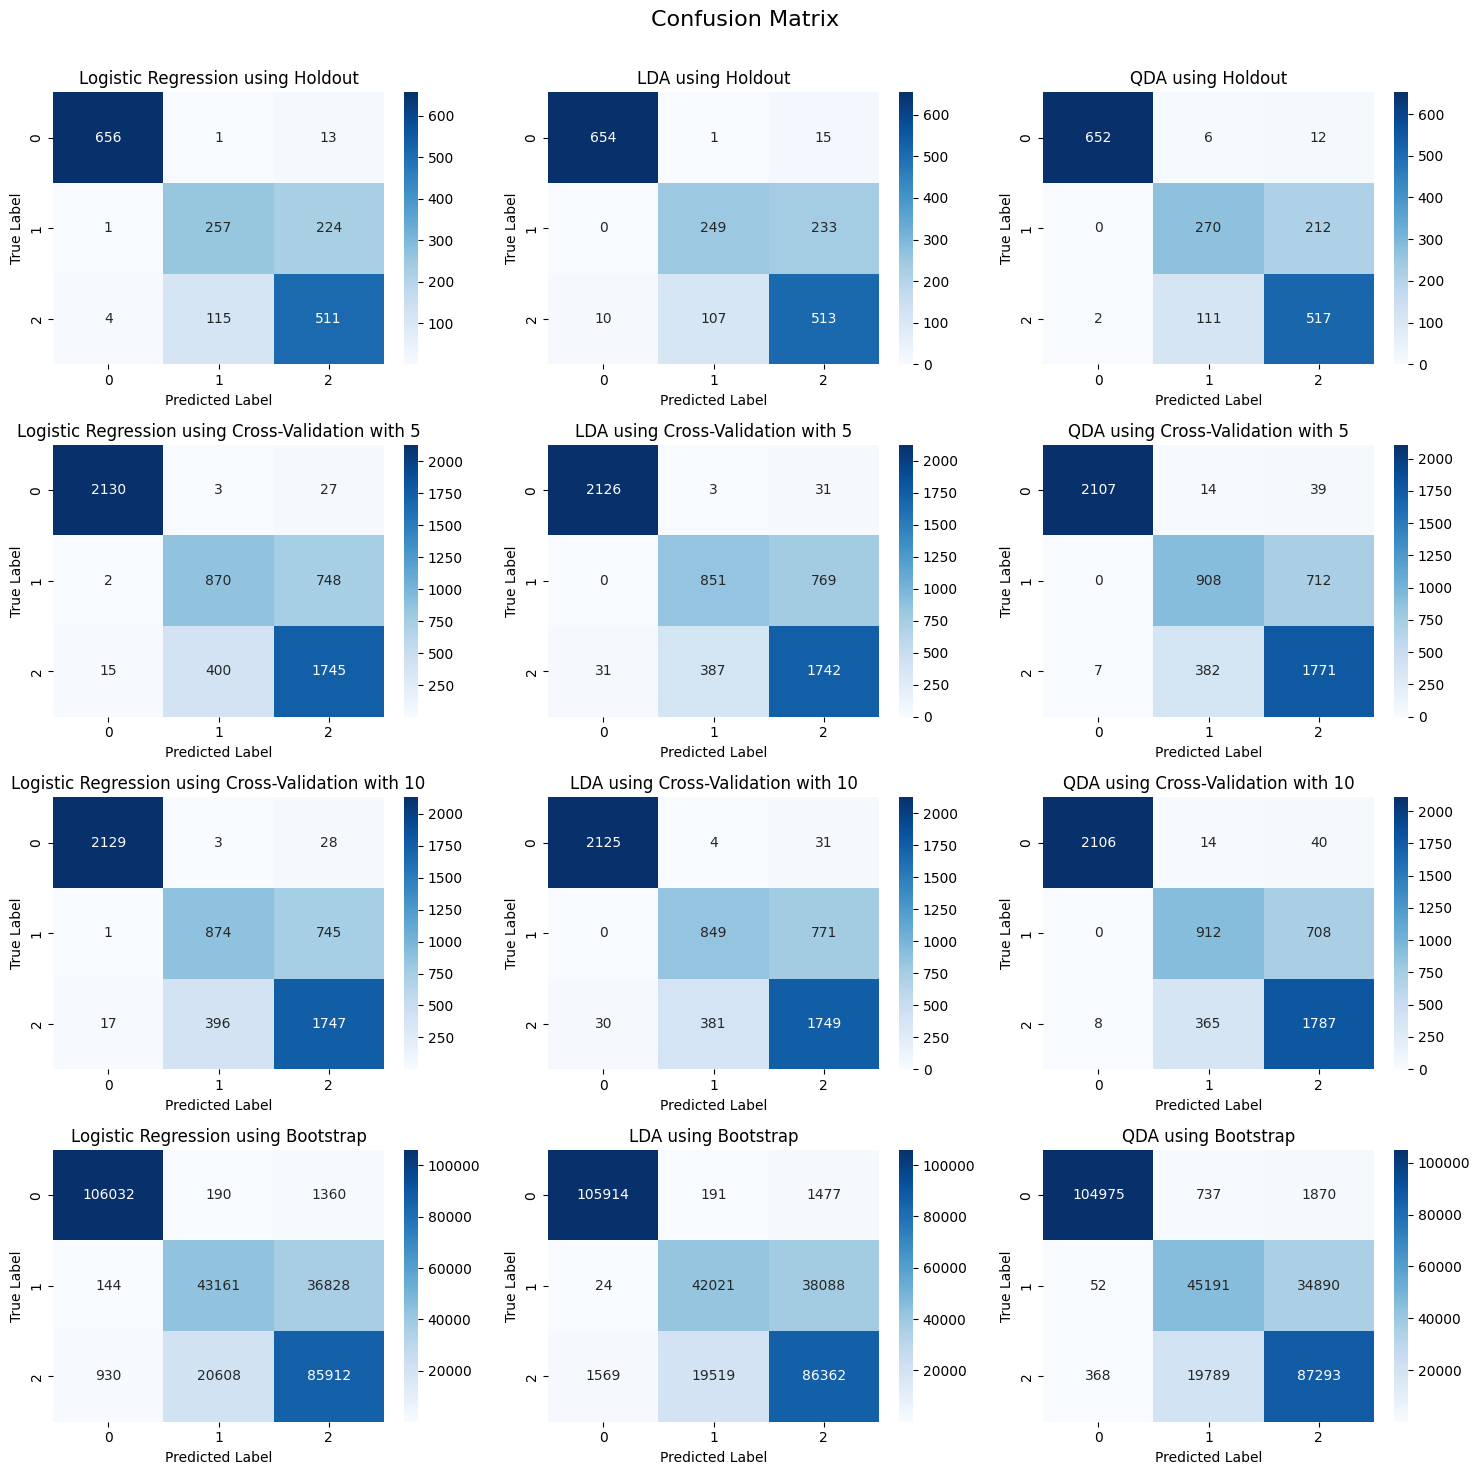

In [30]:
confusion_matrix_visualization(data_results, 'Confusion Matrix')

With theses confusion matrices, we can see that the all the models can easily identify the first Vegetation Type, while for the other two, it has more difficulty in distinguising between them, resulting in a lot of wrong predictions. This is expected considering that, as we saw in our analysis before, there aren't many features which provide a distinction between the Vegetation Types 3 and 6.

In order to improve our results, we need to study which features have a higher impact in the metrics for the models, and select the ones that provide the best results.

## Feature Selection

In [31]:
col_names = X.columns

### Ridge

Ridge Tuning Parameter:  0.1
Ridge Model Intercept:  1.0096200096200085


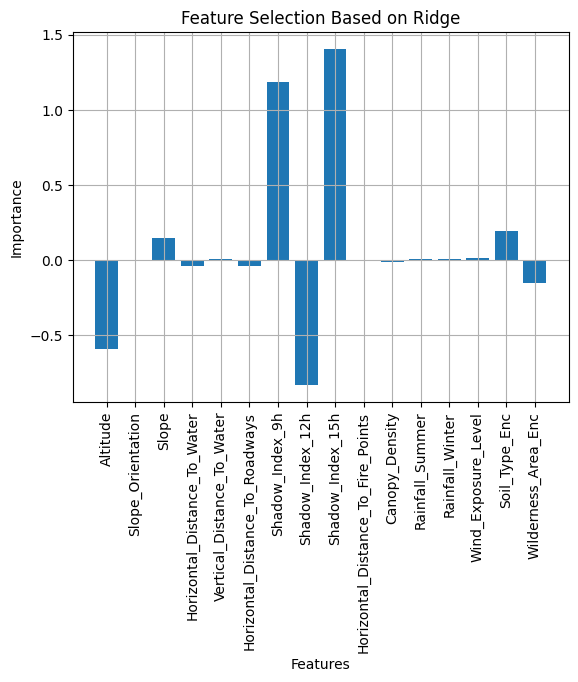

Ridge Regression Model RMSE is:  0.5065085162943737
Ridge Regression Model Training Score:  64.08530221755898
Ridge Regression Model Testing Score:  64.80848952982505


In [32]:
apply_ridge(col_names, X_train, y_train, X_test, y_test)

### Lasso

Lasso tuning parameter: 0.1
Lassso model intercept: 1.0096200096200094


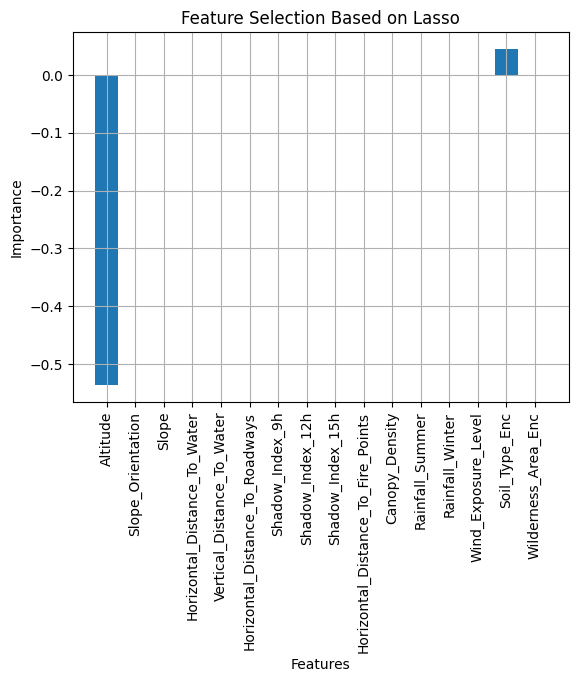

Lasso Regression Model RMSE is:  0.5403369026656353
Lasso Regression Model Training Score:  59.02504648497781
Lasso Regression Model Testing Score:  59.9508169013732


In [33]:
apply_lasso(col_names, X_train, y_train, X_test, y_test)

### Elastic Net

ElasticNet tuning parameter: 0.1
ElasticNet model intercept: 1.0096200096200094


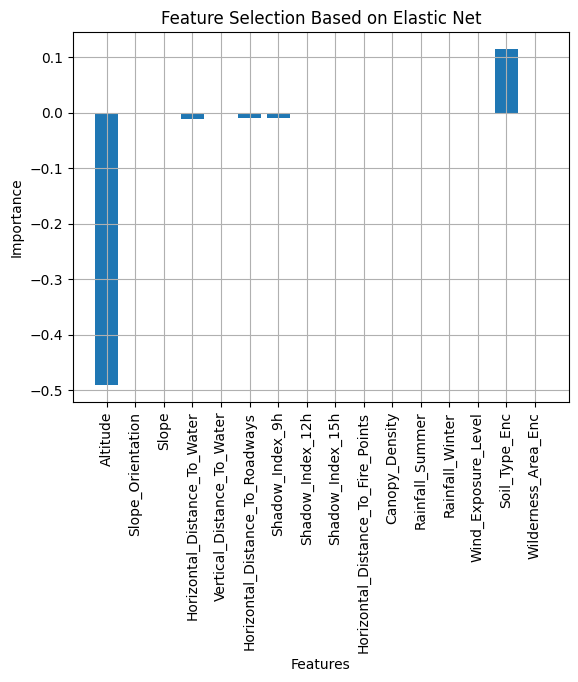

ElasticNet Regression Model RMSE is:  0.5350475236078132
ElasticNet Regression Model Training Score:  59.945498395443785
ElasticNet Regression Model Testing Score:  60.73106521407865


In [34]:
apply_elastic_net(col_names, X_train, y_train, X_test, y_test)

- Having used all of these regularization methods, we first need to decide which one we will use to decide the features.
- We can make this decision based on the models' RMSE, training and testing score, along with the coeficients each one produced. So, considering this, we can determine that Ridge Regression gave us the best results seeing as it resulted in a higher score for both the training and testing datasets, and the lowest RMSE. Besides that, we can also extract more information from the coeficients, like the impact of the Shadow_Index_9h, Shadow_Index_12h, Shadow_Index_15h features, which are omitted in the other models.

- Now we can make adjustments to the dataset's features and verify the results, which will be done next.

#### Data preparation with best features

In [35]:
# Dropping features with lowest coeficients from Ridge method

new_X = X.drop(
    columns=[
        'Slope_Orientation',
        'Vertical_Distance_To_Water',
        'Horizontal_Distance_To_Fire_Points',
        'Canopy_Density',
        'Rainfall_Summer',
        'Rainfall_Winter',
        'Wind_Exposure_Level'
    ]
)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=42)

In [36]:
# Rescaling each feature to have a mean of 0 and a standard deviation of 1

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Holdout With Best Features

In [37]:
holdout_evaluation(data_results, models, X_train, X_test, y_train, y_test, " with best features + ")

### Cross Validation (K=5) With Best Features

In [38]:
cross_validation_evaluation(data_results, models, new_X, y, 5, " with best features +")

### Cross Validation (K=10) With Best Features

In [39]:
cross_validation_evaluation(data_results, models, new_X, y, 10, " with best features +")

### Leave One Out Cross Validation (LOOCV) With Best Features

In [40]:
#loocv_evaluation(data_results, models, new_X, y, " with best features")

### Bootstrap With Best Features

In [41]:
bootstrap_evaluation(data_results, models, new_X, y, 100, " with best features +")

### Results

In [42]:
data_results

,Model,Method,Accuracy,Precision,Recall,F1,Std Dev,Confusion Matrix
0,Logistic Regression,Holdout,0.799102,0.801022,0.799102,0.795422,Nan,"[[656, 1, 13], [1, 257, 224], [4, 115, 511]]"
1,LDA,Holdout,0.794613,0.797298,0.794613,0.789970,Nan,"[[654, 1, 15], [0, 249, 233], [10, 107, 513]]"
2,QDA,Holdout,0.807520,0.810205,0.807520,0.805016,Nan,"[[652, 6, 12], [0, 270, 212], [2, 111, 517]]"
3,Logistic Regression,Cross-Validation with 5,0.798822,0.799251,0.798822,0.794894,0.005952,"[[2130, 3, 27], [2, 870, 748], [15, 400, 1745]]"
4,LDA,Cross-Validation with 5,0.794444,0.794859,0.794444,0.789895,0.0067,"[[2126, 3, 31], [0, 851, 769], [31, 387, 1742]]"
5,QDA,Cross-Validation with 5,0.805724,0.807798,0.805724,0.803017,0.005172,"[[2107, 14, 39], [0, 908, 712], [7, 382, 1771]]"
6,Logistic Regression,Cross-Validation with 10,0.799663,0.800198,0.799663,0.795706,0.020797,"[[2129, 3, 28], [1, 874, 745], [17, 396, 1747]]"
7,LDA,Cross-Validation with 10,0.795118,0.796028,0.795118,0.790459,0.018763,"[[2125, 4, 31], [0, 849, 771], [30, 381, 1749]]"
8,QDA,Cross-Validation with 10,0.808923,0.811558,0.808923,0.806046,0.014526,"[[2106, 14, 40], [0, 912, 708], [8, 365, 1787]]"
9,Logistic Regression,Bootstrap,0.796525,0.796535,0.796525,0.792745,0.005988,"[[106032, 190, 1360], [144, 43161, 36828], [93..."


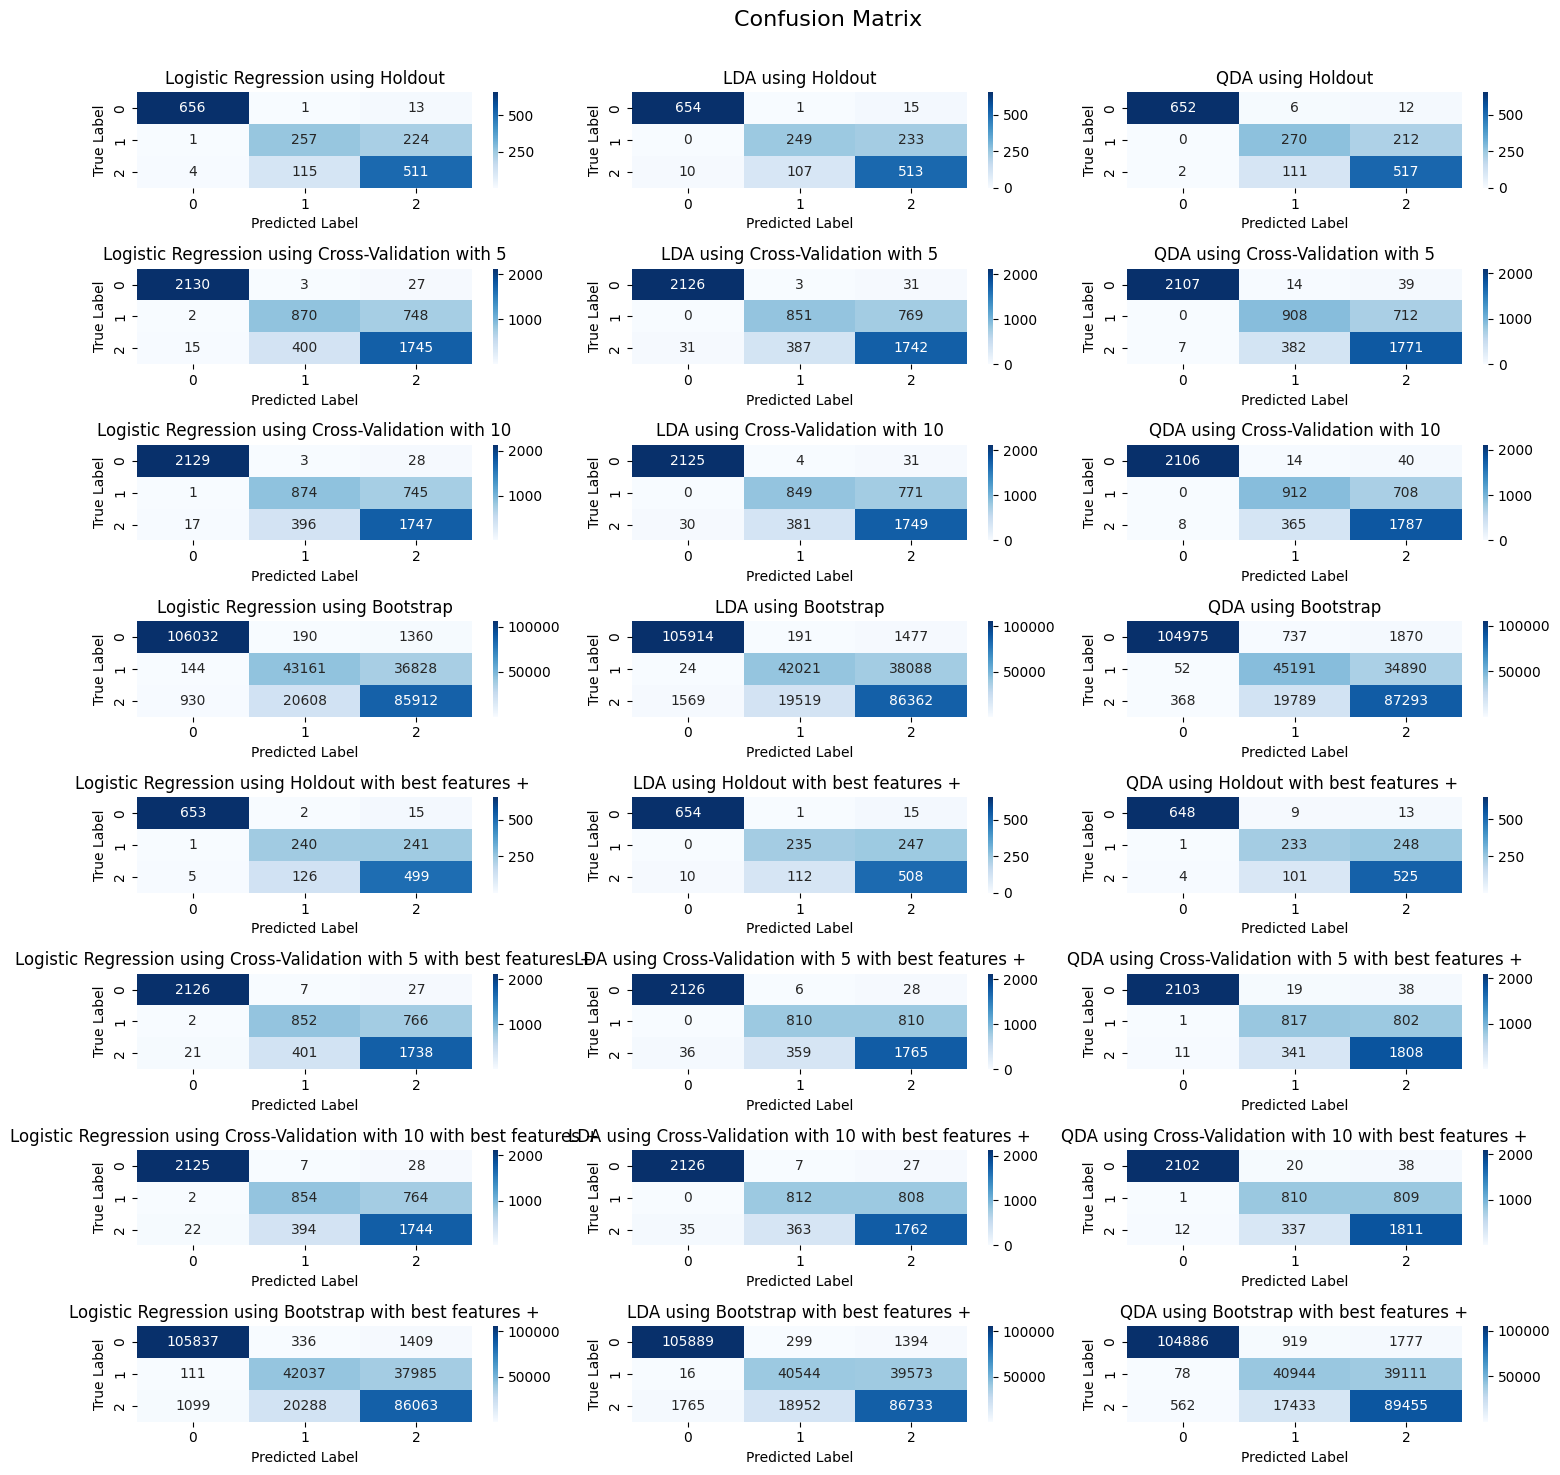

In [43]:
confusion_matrix_visualization(data_results, 'Confusion Matrix')

The results were not what we expected since there is still a big misclassification betweeen the label 1 that is often classified as 2.

We tried getting the dummies of the categorical classes and only using the columns that had correlation with the objective above 0.3 since we considered that smaller values could indicate no correlation at all and few columns had values higher. Surprisingly the results did not improve.

Next we will apply the regularization methods to the data with dummies and test the methods with the suggested columns.

### Get  data with Dummies

In [44]:
# Drop the encoded columns and get the dummies of the categorical columns

new_data =encoded_data_without_id.drop(
    columns=[
        'Vegetation_Type',
        'Soil_Type_Enc',
        'Wilderness_Area_Enc'
    ]
)
data_dummies = pd.get_dummies(new_data)

In [45]:
# Generate the correlation matrix

corr_matrix = data_dummies.corr(numeric_only=True)
sorted_corr = corr_matrix['Vegetation_Type_Enc'].sort_values()

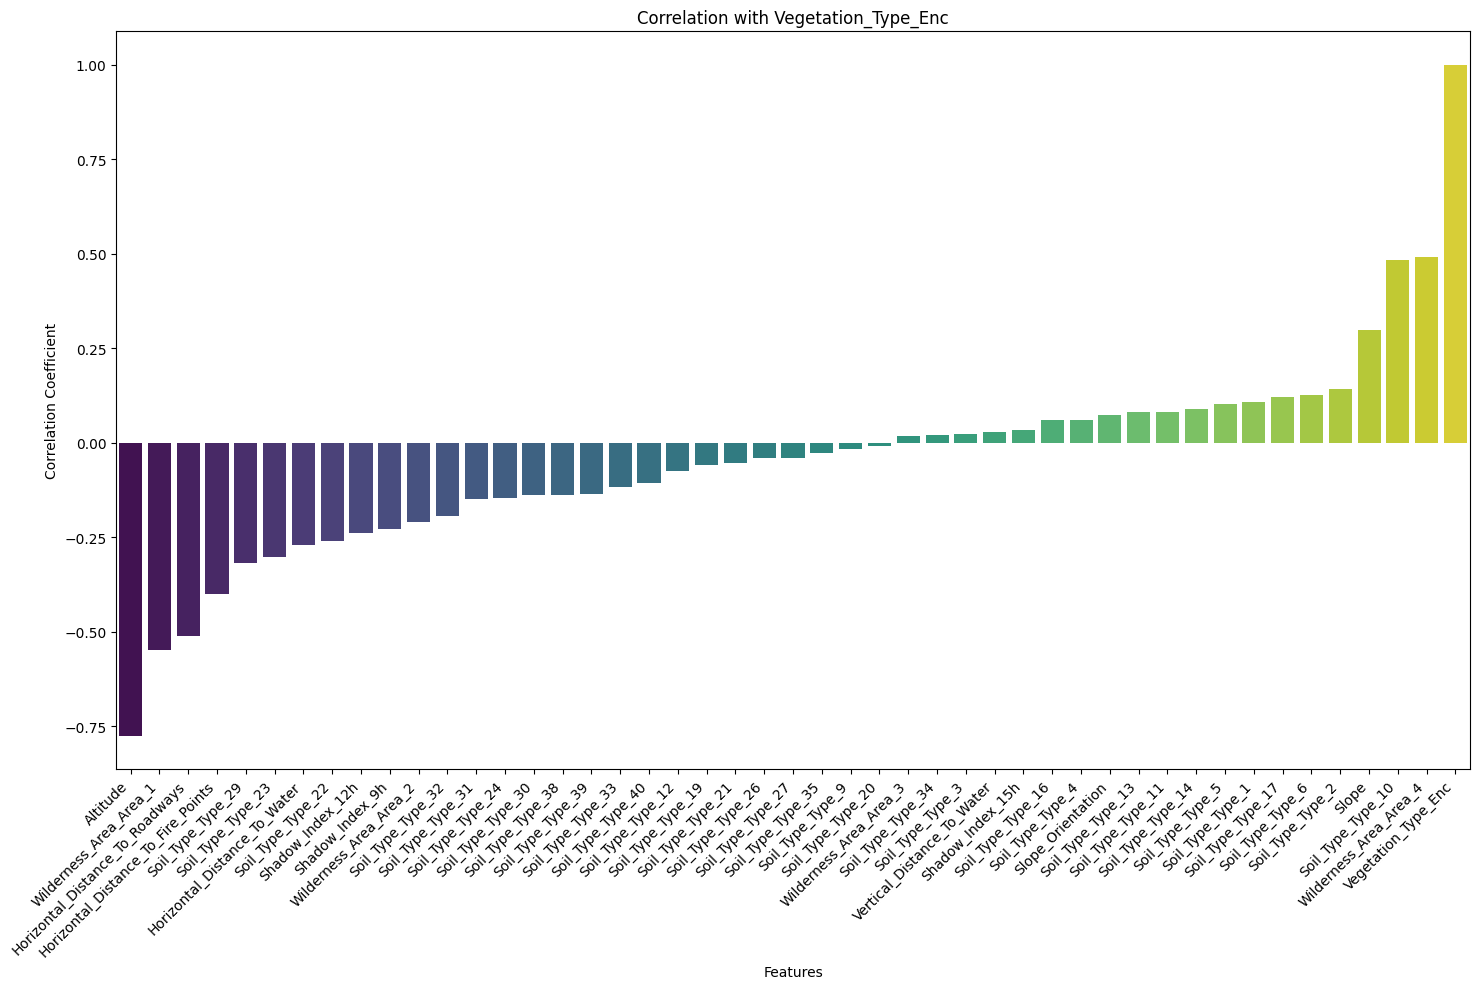

In [57]:
# Plotting the sorted correlations

barplot_correlation_visualization(sorted_corr, 'Correlation with Vegetation_Type_Enc')

The correlation of the features with the target column varies a lot and we can see that we have both highly correlated and uncorrelated features. We will utilize the columns with higher correlation to predict the target column.

### Data Preparation with Dummies

In [47]:
# Preparing the data to use in the regularization methods

X = data_dummies.drop(columns=['Vegetation_Type_Enc'])
y = data_dummies['Vegetation_Type_Enc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

col_names = X.columns

Ridge Tuning Parameter:  0.1
Ridge Model Intercept:  0.8142388191113469


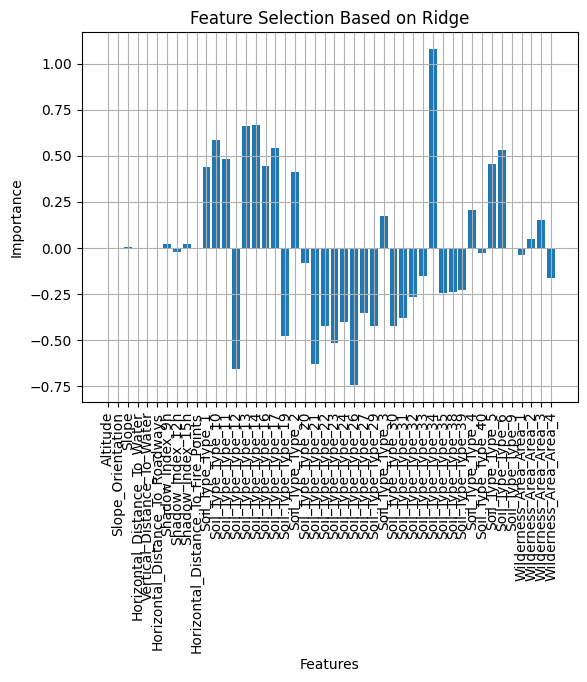

Ridge Regression Model RMSE is:  0.4451110001893567
Ridge Regression Model Training Score:  72.50948518418548
Ridge Regression Model Testing Score:  72.8230285193569


In [48]:
apply_ridge(col_names, X_train, y_train, X_test, y_test)

Lasso tuning parameter: 0.1
Lassso model intercept: 5.838286998896162


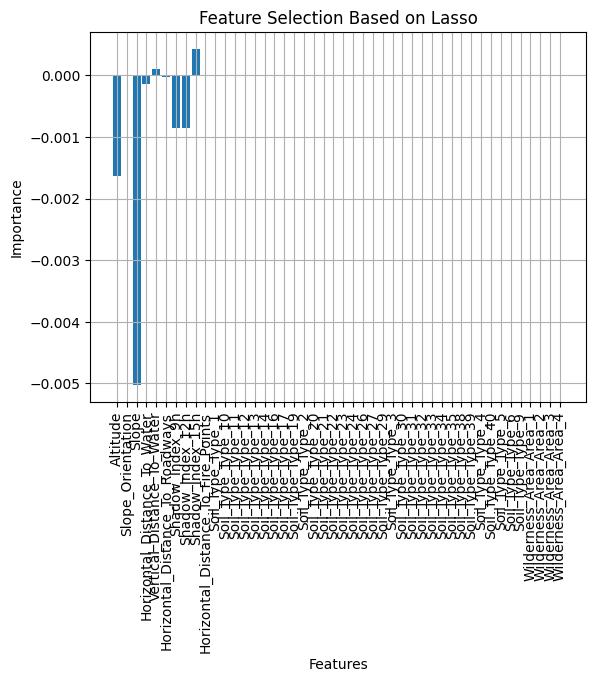

Lasso Regression Model RMSE is:  0.5284068939944637
Lasso Regression Model Training Score:  60.293786215280164
Lasso Regression Model Testing Score:  61.69977244486445


In [49]:
apply_lasso(col_names, X_train, y_train, X_test, y_test)

ElasticNet tuning parameter: 0.1
ElasticNet model intercept: 4.128546897103106


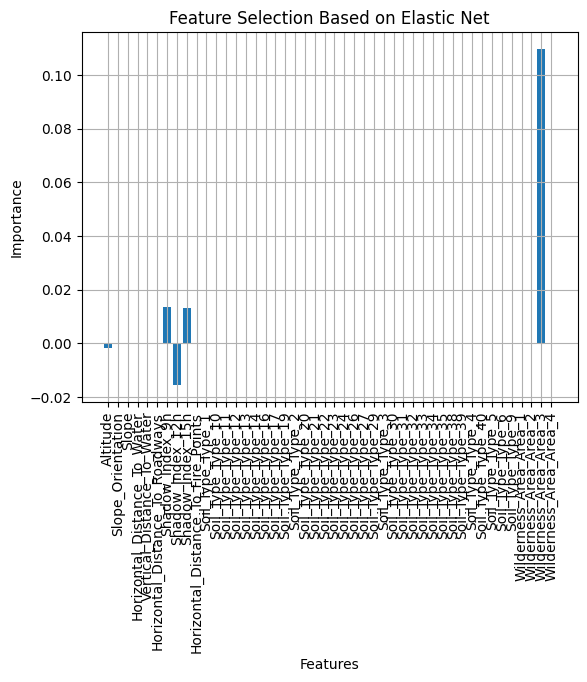

ElasticNet Regression Model RMSE is:  0.5083884515090609
ElasticNet Regression Model Training Score:  63.38676609834407
ElasticNet Regression Model Testing Score:  64.54677415167858


In [50]:
apply_elastic_net(col_names, X_train, y_train, X_test, y_test)

The training results slightly improved, which Ridge method still performing the best. We will keep the columns that have the highest impact on the model and test the results.

### Data Preparation with Best Features and Dummies

In [51]:
# Dropping features with lowest coeficients from Ridge method and splitting the data with the same seed to keep the same data distribution in the training and test datasets

X_dummies =  data_dummies[['Soil_Type_Type_1', 'Soil_Type_Type_10', 'Soil_Type_Type_11', 'Soil_Type_Type_12', 'Soil_Type_Type_13', 'Soil_Type_Type_14', 'Soil_Type_Type_16', 'Soil_Type_Type_17', 'Soil_Type_Type_19', 'Soil_Type_Type_2', 'Soil_Type_Type_21', 'Soil_Type_Type_22', 'Soil_Type_Type_23', 'Soil_Type_Type_24', 'Soil_Type_Type_26', 'Soil_Type_Type_27', 'Soil_Type_Type_29', 'Soil_Type_Type_3', 'Soil_Type_Type_30', 'Soil_Type_Type_31', 'Soil_Type_Type_32', 'Soil_Type_Type_33', 'Soil_Type_Type_34', 'Soil_Type_Type_35', 'Soil_Type_Type_38', 'Soil_Type_Type_39', 'Soil_Type_Type_4', 'Soil_Type_Type_5', 'Soil_Type_Type_6', 'Wilderness_Area_Area_3', 'Wilderness_Area_Area_4']]
y = data_dummies['Vegetation_Type_Enc']

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

### Holdout Method

In [52]:
holdout_evaluation(data_results, models, X_train, X_test, y_train, y_test, " dummies")

### Cross Validation (K=5)

In [53]:
cross_validation_evaluation(data_results, models, new_X, y, 5, " dummies")

### Cross Validation (K=10)

In [54]:
#loocv_evaluation(data_results, models, new_X, y, " dummies")

### Bootstrap

In [55]:
bootstrap_evaluation(data_results, models, new_X, y, 100, " dummies")

### Results with Dummies

In [56]:
data_results

,Model,Method,Accuracy,Precision,Recall,F1,Std Dev,Confusion Matrix
0,Logistic Regression,Holdout,0.799102,0.801022,0.799102,0.795422,Nan,"[[656, 1, 13], [1, 257, 224], [4, 115, 511]]"
1,LDA,Holdout,0.794613,0.797298,0.794613,0.789970,Nan,"[[654, 1, 15], [0, 249, 233], [10, 107, 513]]"
2,QDA,Holdout,0.807520,0.810205,0.807520,0.805016,Nan,"[[652, 6, 12], [0, 270, 212], [2, 111, 517]]"
3,Logistic Regression,Cross-Validation with 5,0.798822,0.799251,0.798822,0.794894,0.005952,"[[2130, 3, 27], [2, 870, 748], [15, 400, 1745]]"
4,LDA,Cross-Validation with 5,0.794444,0.794859,0.794444,0.789895,0.0067,"[[2126, 3, 31], [0, 851, 769], [31, 387, 1742]]"
5,QDA,Cross-Validation with 5,0.805724,0.807798,0.805724,0.803017,0.005172,"[[2107, 14, 39], [0, 908, 712], [7, 382, 1771]]"
6,Logistic Regression,Cross-Validation with 10,0.799663,0.800198,0.799663,0.795706,0.020797,"[[2129, 3, 28], [1, 874, 745], [17, 396, 1747]]"
7,LDA,Cross-Validation with 10,0.795118,0.796028,0.795118,0.790459,0.018763,"[[2125, 4, 31], [0, 849, 771], [30, 381, 1749]]"
8,QDA,Cross-Validation with 10,0.808923,0.811558,0.808923,0.806046,0.014526,"[[2106, 14, 40], [0, 912, 708], [8, 365, 1787]]"
9,Logistic Regression,Bootstrap,0.796525,0.796535,0.796525,0.792745,0.005988,"[[106032, 190, 1360], [144, 43161, 36828], [93..."
